# Exploring and Benchmarking XGBoost Against Other Machine Learning Models

---

## Part I: Understanding XGBoost

### Introduction
- Briefly introduce machine learning and the role of ensemble learning

### Background on Boosting
- Explain the concept of boosting in machine learning.
- Historical evolution leading to gradient boosting.

### XGBoost Overview
- Detailed explanation of XGBoost and its core algorithm.
- Advantages of XGBoost over other boosting methods.

### Key Concepts and Features of XGBoost
- Discuss tree boosting, regularized learning, and model complexity.
- Overview of handling missing data, parallel processing, and scalability.

### XGBoost Parameters
- List and explain crucial XGBoost hyperparameters.
- Show how these parameters can affect model performance.

### Installation and Setup
- Guide on setting up XGBoost in a development environment.

### Data Preparation
- Discuss the preprocessing required for optimal XGBoost performance.

### Model Training with XGBoost
- Step-by-step process of training an XGBoost model.
- Techniques for evaluating model performance.

### Interpretation of Results
- How to interpret model outputs, importance scores, and diagnostics.

---

## Part II: Performance Comparison of XGBoost

### <u>Benchmarking Goals</u>
- Define the objectives of the performance comparison.

The objectives of the performance comparison are to:
- Compare the performance of XGBoost against other machine learning models.
- Determine the optimal hyperparameters for each model.
- Identify the best model for the given dataset (may or may not be XGBoost).

### <u>Selection of Competing Models</u>
- Choose a set of models for comparison (e.g., Random Forest, SVM, Neural Networks).

We're using six machine learning models for comparison. Here is a brief description of each:

1. **MLP (Multi-Layer Perceptron)**: A type of neural network with multiple hidden layers, effective for complex classification tasks.

2. **GradientBoosting**: A simpler gradient boosting classifier with fewer hyperparameters, ideal as a starting point.

3. **k-NN (k-Nearest Neighbors)**: Simple for low-dimensional data but computationally heavy for large datasets.

4. **Random Forest**: A popular method using multiple decision trees, effective for both classification and regression.

5. **SVM (Support Vector Machine)**: Effective in high-dimensional spaces but can be slower than gradient boosting methods.

6. **XGBoost (Extreme Gradient Boosting)**: Highly efficient and versatile, suitable for various supervised learning tasks.

### <u>Dataset Description</u>
- Introduce the dataset(s) used for the comparison.
- Include feature descriptions and any preprocessing steps.

### <u>Performance Metrics</u>
- Define the metrics for evaluating model performance (e.g., accuracy, F1 score, ROC-AUC).

For our classification models, we use seven metrics to evaluate performance:

1. **Accuracy**: Ratio of correct predictions. Useful overall but can mislead in imbalanced datasets.

2. **Precision**: Ratio of correct positive predictions. Vital when false positives are costly.

3. **Recall (Sensitivity)**: Ratio of correct positives out of all actual positives. Key when false negatives are costly.

4. **F1-Score**: Balances Precision and Recall. Used when both metrics are important.

5. **AUC-ROC**: Indicates the model's ability to differentiate classes. Higher values are better.

6. **AUC-PR**: Focuses on performance regarding the positive class, crucial in imbalanced datasets.

7. **Training Time**: Measures computational efficiency, important in scenarios with computational constraints.

### <u>Cross-Validation Strategy</u>
- Explain the cross-validation process to ensure fairness in comparison.

### <u>Hyperparameter Tuning</u>
- How each model's hyperparameters are tuned for optimal performance.

### <u>Model Training and Evaluation</u>
- Train the selected models on the dataset.
- Evaluate and compare their performance using the defined metrics.

Using default params for all models:

In [1]:
# Standard libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# Sklearn modules
from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, average_precision_score, classification_report, confusion_matrix, 
                             f1_score, precision_recall_curve, precision_score, recall_score, roc_auc_score, 
                             roc_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsClassifier as KNN
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, MinMaxScaler, OneHotEncoder, OrdinalEncoder, 
                                   PolynomialFeatures, StandardScaler)
from sklearn.svm import SVC

# Third-party libraries
from xgboost import XGBClassifier

# pd max cols
pd.set_option('display.max_columns', 500)

In [ ]:
def titanic_transformed():

    # Load Titanic data
    t_data = pd.read_csv('../../data_science_analytics_class/Data/titanic.csv')

    # Group ticket feature extraction
    group_tickets = t_data['Ticket'].value_counts() > 1
    t_data['Is_Group'] = t_data['Ticket'].apply(lambda x: 1 if group_tickets[x] else 0)
    t_data['Group_Size'] = t_data['Ticket'].map(t_data['Ticket'].value_counts())

    # Functions for title and family size extraction
    def get_title(data):
        titles = data['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
        common_titles = titles.value_counts().nlargest(6).index
        return titles.where(titles.isin(common_titles), 'Other')

    def get_family_size(data):
        return data['SibSp'] + data['Parch'] + 1

    # Transformation pipelines
    numerical_features = ['Age', 'Fare', 'FamilySize', 'Group_Size']
    numerical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ])

    categorical_features = ['Sex', 'Embarked', 'Title', 'Pclass']
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Apply the custom transformations
    t_data['Title'] = get_title(t_data)
    t_data['FamilySize'] = get_family_size(t_data)

    # Column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    # Fit the transformer and transform the data
    transformed_data = preprocessor.fit_transform(t_data)

    # Getting the column names for numerical features
    numerical_cols = numerical_features

    # Getting the column names for categorical features
    categorical_cols = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)

    # Combine all column names
    all_cols = list(numerical_cols) + list(categorical_cols)

    # Add any remaining columns that were 'passed through'
    pass_through_cols = [col for col in t_data.columns if col not in numerical_features + categorical_features]
    all_cols.extend(pass_through_cols)

    # Create the DataFrame
    transformed_df = pd.DataFrame(transformed_data, columns=all_cols)

    transformed_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

    # Set all dtypes to float
    transformed_df = transformed_df.astype(float)

    return transformed_df

c:\Users\bovam\miniconda3\envs\aispace\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


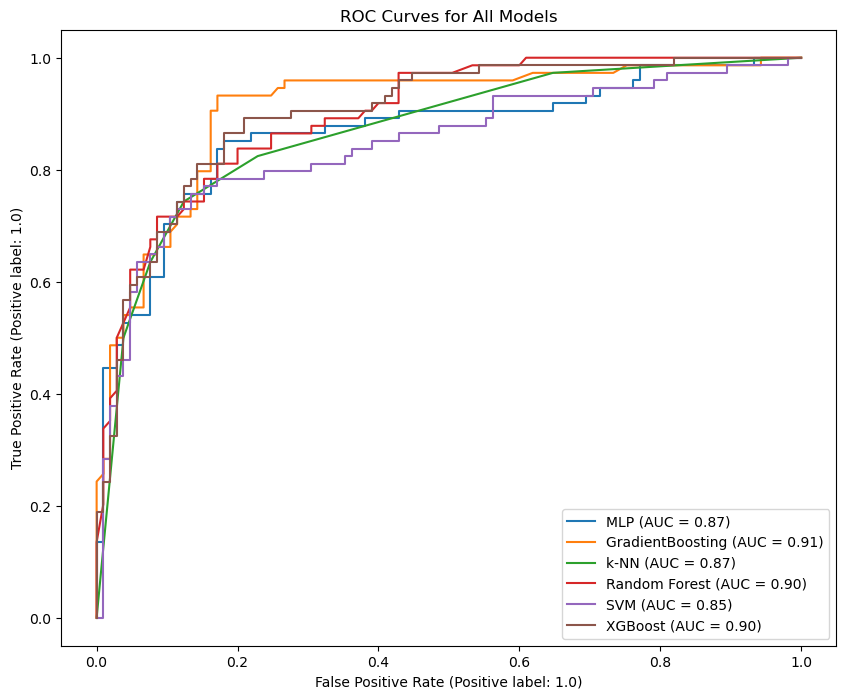

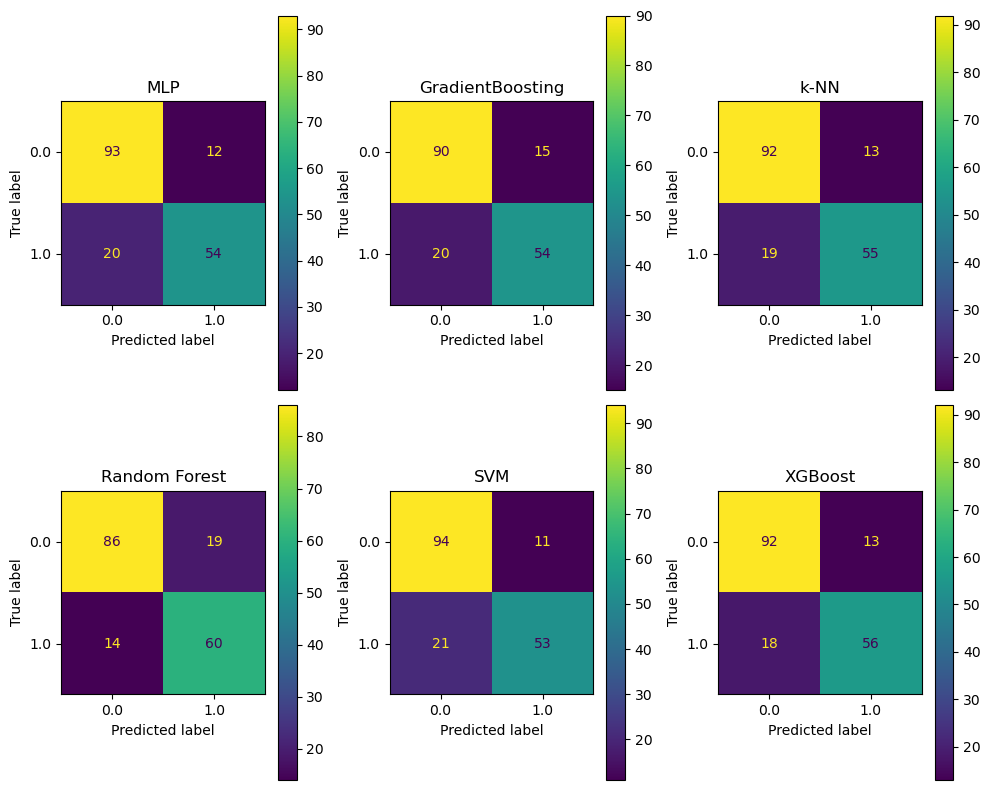

C:\Users\bovam\AppData\Local\Temp\ipykernel_1120\3024388201.py:87: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  styled_results = results_df_transposed.style.apply(highlight_max).set_precision(3)


,Accuracy,Precision,Recall,F1-Score,Training Time
MLP,0.821,0.821,0.821,0.819,2.270
GradientBoosting,0.804,0.803,0.804,0.803,0.188
k-NN,0.821,0.821,0.821,0.820,0.073
Random Forest,0.816,0.818,0.816,0.816,0.650
SVM,0.821,0.822,0.821,0.819,0.126
XGBoost,0.827,0.826,0.827,0.826,0.105


In [42]:
# Load transformed titanic data
titanic_data = titanic_transformed()

# Feature matrix X, target vector y
X = titanic_data.drop(['Survived'], axis=1)
y = titanic_data['Survived']


models = {
    "MLP": MLPClassifier(max_iter=1000),
    "GradientBoosting": GradientBoostingClassifier(),
    "k-NN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

def evaluate_model(model, X_train, X_test, y_train, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    end = time.time()
    training_time = end - start
    scores = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred, average='weighted'),
        # "AUC-ROC": roc_auc_score(y_test, y_score, average='weighted'),
        # "AUC-PR": average_precision_score(y_test, y_score, average='weighted'), # Not directly supported for multiclass
        "Training Time": training_time
    }
    # Create plots to add to dictionary
    cm = confusion_matrix(y_test, y_pred)
    cm_display_data = (cm, model.classes_)
    
    # Store the model and test set for ROC curve plotting
    roc_data = (model, X_test, y_test)

    plots = {
        "Confusion_Matrix": cm_display_data,
        "ROC_Curve": roc_data
    }
    return scores, plots

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = {}
plots = {}
for name, model in models.items():
    results[name], plots[name] = evaluate_model(model, X_train, X_test, y_train, y_test)

results_df = pd.DataFrame(results)
results_df

# Plot ROC curves in a separate figure
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))
for model_name in models.keys():
    model, X_test, y_test = plots[model_name]["ROC_Curve"]
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax_roc, name=model_name)
ax_roc.set_title('ROC Curves for All Models')
ax_roc.legend()
plt.show()

# Plot confusion matrices in another separate figure
fig_cm, axes_cm = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))  # Adjust nrows and ncols based on the number of models
axes_cm = axes_cm.flatten()  # Flatten the array for easy iteration
for i, model_name in enumerate(models.keys()):
    cm, classes = plots[model_name]["Confusion_Matrix"]
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(ax=axes_cm[i])
    axes_cm[i].set_title(f"{model_name}")
fig_cm.tight_layout()
plt.show()

def highlight_max(s):
    '''
    Highlight the maximum value in a Series with a green background.
    '''
    is_max = s == s.max()
    return ['background-color: green' if cell else '' for cell in is_max]
# Transpose the DataFrame for better readability
results_df_transposed = results_df.T
# Apply the highlighting style
styled_results = results_df_transposed.style.apply(highlight_max).set_precision(3)
styled_results

#### Titanic data testing zone
---

Fitting 5 folds for each of 96 candidates, totalling 480 fits
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       134
           1       0.79      0.67      0.73        89

    accuracy                           0.80       223
   macro avg       0.80      0.78      0.78       223
weighted avg       0.80      0.80      0.79       223



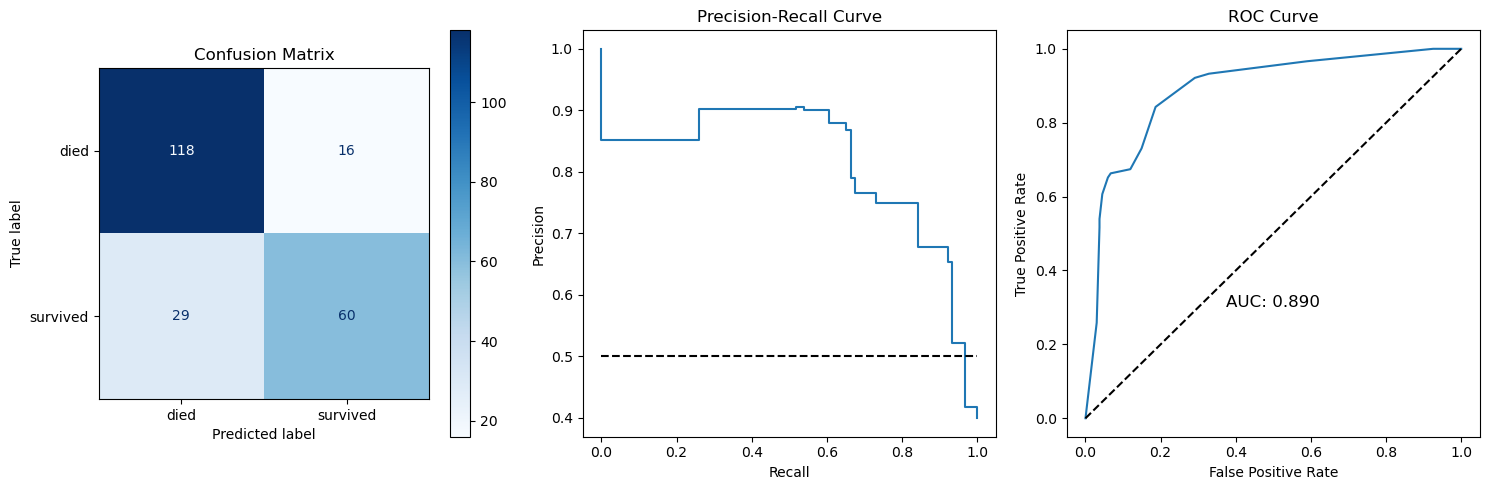

In [10]:
# Load Titanic data
t_data = pd.read_csv('../../data_science_analytics_class/Data/titanic.csv')

# save the tickets that appear more than once (i.e. group tickets)
_ = (t_data.Ticket.value_counts()>1).to_dict()
ls = []
for key in _:
    if _[key]==True:
        ls.append(key)
#extract the feature
t_data['Is_Group'] = t_data['Ticket'].apply(lambda x: 1 if x in(ls) else 0)

# create another dict containing the number of counts per each ticket
group_size = (t_data.Ticket.value_counts()).to_dict()
# extract the feature from the mapping
t_data['Group_Size'] = t_data['Ticket'].map(group_size).fillna(0)

# Function to extract title from name
def get_title(data):
    df = data.copy()
    df['Title'] = df.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
    most_common_titles = df['Title'].value_counts().head(6).index.tolist()
    df.loc[~df['Title'].isin(most_common_titles), 'Title'] = 'Other'
    return df

get_title_transformer = FunctionTransformer(get_title)

# Function to calculate family size
def get_family_size(data):
    df = data.copy()
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    return df

get_family_size_transformer = FunctionTransformer(get_family_size)

# Numerical features pipeline
numerical_features = ['Age', 'Fare', 'FamilySize']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Categorical features pipeline
categorical_features = ['Sex', 'Embarked', 'Title', 'Pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Classifier
knn_clf = KNN()

# Classification pipeline
pipe_clf = Pipeline(
    steps=[
        ('get_title', get_title_transformer),
        ('get_family_size', get_family_size_transformer),
        ('preprocessor', preprocessor),
        ('poly_features', PolynomialFeatures()),
        ('knn', knn_clf)
    ]
)

# Feature matrix and target vector
X = t_data.drop(['Survived', 'PassengerId', 'Ticket', 'Cabin'], axis=1)
y = t_data['Survived']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Grid search
param_grid = {
    'knn__n_neighbors': list(range(1, 25)),
    'knn__weights': ['uniform', 'distance'],
    'poly_features__degree': [1, 2]
}
grid_search = GridSearchCV(
    pipe_clf,
    param_grid,
    cv=5,
    scoring='accuracy',
    error_score='raise',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best classifier
best_clf = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Draw confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['died', 'survived'])

# Draw pr curve
y_score = best_clf.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_score)
pr_display = PrecisionRecallDisplay(precision=precisions, recall=recalls)

# Draw roc auc curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

# Plot all on one figure
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
disp.plot(ax=ax[0], cmap='Blues')
pr_display.plot(ax=ax[1])
roc_display.plot(ax=ax[2])
# add auc score to plot
ax[2].text(0.5, 0.3, f'AUC: {roc_auc_score(y_test, y_score):.3f}', fontsize=12, ha='center')
ax[0].set_title('Confusion Matrix')
ax[1].set_title('Precision-Recall Curve')
ax[2].set_title('ROC Curve')
# draw chance line
ax[1].plot([0, 1], [0.5, 0.5], linestyle='--', color='black')
ax[2].plot([0, 1], [0, 1], linestyle='--', color='black')
fig.tight_layout()
plt.show()

---

### <u>Result Analysis</u>
- Present the comparison results in tables or graphs.
- Statistical tests, if applicable, to establish significant differences.

### <u>Discussion</u>
- Interpret the comparison findings.
- Discuss where XGBoost outperforms or underperforms.

### <u>Conclusion</u>
- Summarize key takeaways from the XGBoost exploration and model comparison.

---

## Appendices and Supporting Materials

- Code snippets, Jupyter Notebook links, or GitHub repository.
- Detailed tables and graphical representations of results.
- Additional notes on the computational environment, data access, etc.

### References:
- https://xgboost.readthedocs.io/en/latest/
- https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn